# Stepwise Regression (NON-PCA) 

This notebook demonstrates:
1. Loading measured streamflow and tree-ring chronology data
2. Aligning predictors and target (1906–1995)
3. Running stepwise feature selection to choose predictors
4. Fitting regression on first half, validating on second half
5. Plotting observed vs predicted on validation period

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt


## 1) Load input data

In [2]:
excel_path = 'Data/upper-colorado-trees.xls'   # input file
sheet_name = 'standard chrons'                 # sheet with data
header_row = 1                                  # 0-based row index for header (Excel row 2)
year_min, year_max = 1490, 1998
n_components = 30                               # number of PCs to compute


columns = ['YEAR','PIC','WIL','COL','PLU','MCP','SAR','UNA','ATR','PUM','RED','RIF','CAT','GMR','ENC','DOU','TRG','COD','MTR','PRP','NPU','SLK','EAG','BEN','RUS','JFU','FBN','DJM','NUR','RPC','WED']

In [3]:
# Read Excel and keep only the needed columns
df = pd.read_excel(excel_path, sheet_name=sheet_name, header=header_row)

# Simple column check, then select
missing = [c for c in columns if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in the Excel sheet: {missing}")

df_sel = df[columns].copy()

# Keep rows within the target year range
mask = (df_sel['YEAR'] >= year_min) & (df_sel['YEAR'] <= year_max)
df_years = df_sel.loc[mask].copy()

# Set YEAR as index 
df_years = df_years.set_index('YEAR')

# Peek
#df_years.head()

## 2) Stepwise feature selection

Years used: 1906–1995, n=90
Predictors available: 30

=== Best subset (sequential selection) ===
Direction: forward
Scoring : neg_mean_squared_error
k       : 7
Features: ['WIL', 'UNA', 'PUM', 'TRG', 'PRP', 'NPU', 'DJM']
CV neg-MSE: -5625454.4877 ± 1516613.8736


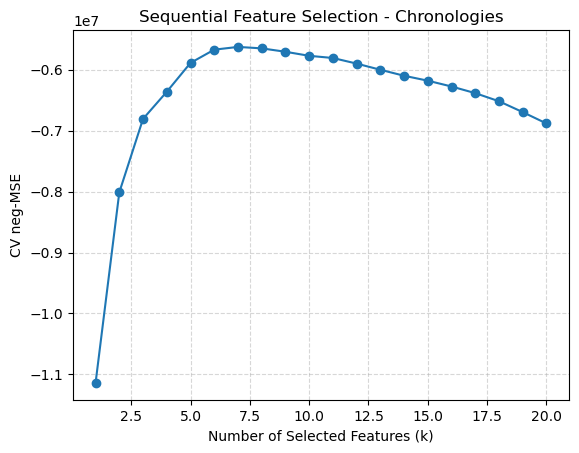


Top coefficients (abs):
TRG    1310.556593
WIL    1297.917011
PUM     985.318308
UNA     948.386716
DJM     908.948389
PRP     594.090281
NPU     537.946442
dtype: float64


In [4]:
nf = pd.read_excel('Data/Measured Streamflow in MAF.xlsx', header=0, index_col=0)

target_col = "Meko Paper"
year_min, year_max = 1906, 1995

# 1) Make sure indices are numeric and sorted
nf = nf.copy()
df_years = df_years.copy()
nf.index = pd.to_numeric(nf.index, errors='coerce')
df_years.index = pd.to_numeric(df_years.index, errors='coerce')
nf = nf.sort_index()
df_years = df_years.sort_index()

# 2) Use only predictor/site columns (exclude 'YEAR' since it's the index)
site_cols = [c for c in df_years.columns if c != 'YEAR']

# 3) Slice by year and inner-join to align rows
X_raw = df_years.loc[year_min:year_max, site_cols]
y_raw = nf.loc[year_min:year_max, target_col]
data = X_raw.join(y_raw, how="inner").dropna(axis=0)
X = data[site_cols]
y = data[target_col]

print(f"Years used: {int(data.index.min())}–{int(data.index.max())}, n={len(data)}")
print(f"Predictors available: {X.shape[1]}")

# 4) Define model + CV
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# 5) Sequential feature selection (forward). Try k = 1..min(20, p)
direction = "forward"          # change to "backward" if you prefer
scoring = "neg_mean_squared_error"  # or "r2"
max_k = min(20, X.shape[1])

results = []
best_tuple = None

for k in range(1, max_k + 1):
    sfs = SequentialFeatureSelector(
        pipe.named_steps["lr"],
        n_features_to_select=k,
        direction=direction,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )
    sfs.fit(X, y)
    sel = list(X.columns[sfs.get_support()])
    scores = cross_val_score(pipe, X[sel], y, scoring=scoring, cv=cv, n_jobs=-1)
    mean_score, std_score = scores.mean(), scores.std()
    results.append((k, sel, mean_score, std_score))
    if (best_tuple is None) or (mean_score > best_tuple[2]):
        best_tuple = (k, sel, mean_score, std_score)

best_k, best_features, best_score, best_std = best_tuple
print("\n=== Best subset (sequential selection) ===")
print(f"Direction: {direction}")
print(f"Scoring : {scoring}")
print(f"k       : {best_k}")
print(f"Features: {best_features}")
if scoring == "neg_mean_squared_error":
    print(f"CV neg-MSE: {best_score:.4f} ± {best_std:.4f}")
else:
    print(f"CV R²: {best_score:.4f} ± {best_std:.4f}")

# 6) Quick plot: k vs CV score
ks = [r[0] for r in results]
scores = [r[2] for r in results]
plt.figure()
plt.plot(ks, scores, marker='o')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('CV neg-MSE' if scoring == "neg_mean_squared_error" else 'CV R²')
plt.title(f'Sequential Feature Selection - Chronologies')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 7) Fit final model on best subset and show coefficients
final_X = X[best_features]
final_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
final_pipe.fit(final_X, y)
coef_series = pd.Series(final_pipe.named_steps["lr"].coef_, index=best_features).sort_values(key=np.abs, ascending=False)
print("\nTop coefficients (abs):")
print(coef_series.head(10))


## 3) Stepwise regression and get the accuracy scores

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Use the 7 best features that came out of stepwise selection
selected_features = best_features   # should be length = 7
cv1 = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
# Subset predictors
X_sel = X[selected_features]

# --- Training R² (fit on all data) ---
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
final_model.fit(X_sel, y)

y_pred = final_model.predict(X_sel)
r2_in_sample = r2_score(y, y_pred)

print(f"Training R² with 7 features: {r2_in_sample:.4f}")

# --- Cross-validated R² ---
cv_scores = cross_val_score(final_model, X_sel, y, scoring="r2", cv=cv, n_jobs=-1)
print(f"Cross-validated R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

rmse_in_sample = np.sqrt(mean_squared_error(y, y_pred))
print(f"Training RMSE with 7 features: {rmse_in_sample:.4f}")

# cross-validated RMSE using neg_mean_squared_error
cv_rmse_scores = cross_val_score(
    final_model, X_sel, y,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

cv_rmse = np.sqrt(-cv_rmse_scores)  # convert neg-MSE to RMSE
print(f"Cross-validated RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")



Training R² with 7 features: 0.8401
Cross-validated R²: 0.7774 ± 0.0917
Training RMSE with 7 features: 2120.4775
Cross-validated RMSE: 2348.7310 ± 330.0264


## 4) Plotting the Actual streamflow vs the predictions

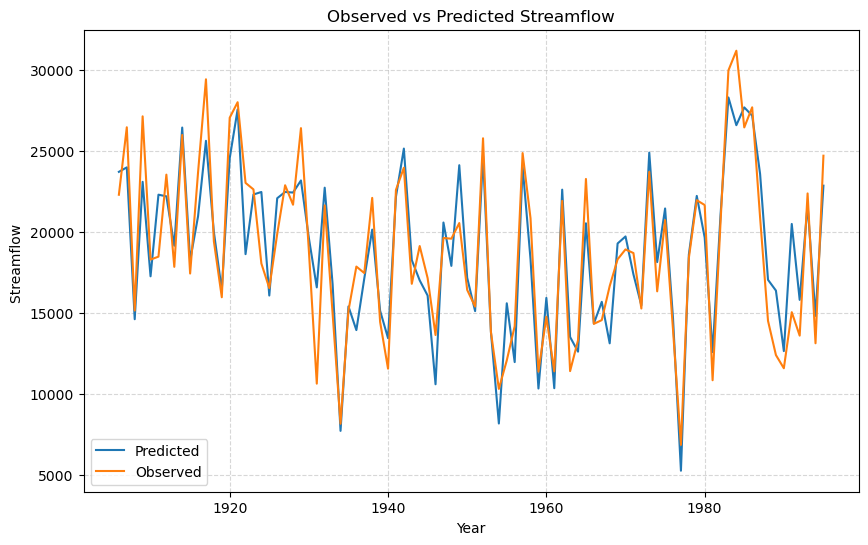

In [6]:
plt.figure(figsize=(10,6))
plt.plot(X_sel.index, y_pred, label="Predicted")
plt.plot(X_sel.index, y_raw, label="Observed")
plt.xlabel('Year')
plt.ylabel('Streamflow ')
plt.title('Observed vs Predicted Streamflow')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

df_out = pd.DataFrame({
    'Year': X_sel.index,
    'Observed_Streamflow': y_raw,
    'Predicted_Streamflow regression (non_pca)': y_pred
})

# Save to Excel
df_out.to_excel('Observed_vs_Predicted_Streamflow_SR.xlsx', index=False)


## 5) Reconstruction

In [7]:
TR_START, TR_END = 1490, 1995
X_paleo = df_years.loc[TR_START:TR_END]

# --- select features from the best model ---
if 'selected_features' in globals() and selected_features:
    X_paleo_use = X_paleo[selected_features].copy()
else:
    X_paleo_use = X_paleo.copy()

# --- Predict with Stepwise / Linear model ---
recon_stepwise = pd.Series(final_model.predict(X_paleo_use), index=X_paleo_use.index, name='recon_stepwise')


# --- Combine & save to Excel ---
out = pd.DataFrame(index=X_paleo_use.index)
out['recon_stepwise'] = recon_stepwise


excel_path = "reconstruction_non_PCA.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    out.to_excel(writer, sheet_name="reconstruction")
    # add a small metadata sheet
    meta = pd.DataFrame({
        "item": ["window", "models_included", "notes"],
        "value": [f"{TR_START}-{TR_END}",
                  "stepwise" ,
                  "Units follow your training target; verify scaling if needed."]
    })
    meta.to_excel(writer, sheet_name="meta", index=False)

print(f"Saved: {excel_path}")


Saved: reconstruction_non_PCA.xlsx
